## <center>Female Character Develoment in Movies - An Analysis using Bechdel Scores</center>
    



<b>Project background:</b> Happy Pride Month!! I originally wanted to analyze LQBTQIA+ presentation in Hollywood but wasn't able to find any freely available data on this. For example, glaad.org has [this great report](https://glaad.org/whereweareontv21) but unfortunately, the data behind the report is not freely available. So I'm focusing instead on gender based representation since this data is pretty easily available from [thebechdeltest](https://bechdeltest.com/). 

The Bechdel-Wallace Test or [(The Rule)](https://dykestowatchoutfor.com/the-rule/) as it was referred to by Alison Bechdel in the comic strip she created in 1985, asks three questions: (1) Are there atleast two female characters in the movie?, (2) Are they shown talking to each other?, and (3) About something other than a man? The Bechdel-Wallance test has come to be one of the more well-known measures of female representation. Over the years, others have added further criteria to the test; this article by [ThirtyFiveEighty](https://projects.fivethirtyeight.com/next-bechdel/) talks about some of them. To keep things simple for my project, I'd like to stick to bechdel scores.

In this project I'm mainly asking the following questions:

* Using the Bechdel Test as a benchmark for representation of female characters in movies, do we see trends improving or deteriorating in Hollywood?

* Does the audience care; do movies that pass the Bechdel Test do better at the box office?

I'm happy to report that we see positive trends; female representation in movies is improving over the years as shown in Figures 1 and 2 below. However, as analyzed in the project details section, unfortunately, the Bechdel dataset does not represent the full universe of Hollywood movies; [the Bechdel dataset is created based on user submissions](https://bechdeltest.com/add/) and it is possible that individuals who report back to the website are more likley to watch movies that would do well on such a test anyway, which may potential instroduce some positive bias in the dataset. So the positive trends we see in this dataset may not converge with a broader and more representative dataset of Hollywood movies.

In terms of box office returns, an analysis of the all time top 100 US movies by domestic box office returns revealed that 73% of these movies pass the Bechdel Test. While there are likely a lot of factors that go into making a movie a success, such as the budget, plot/genre, cast, etc., it appears that bechdel scores do have some predictive power about whether the movie will be a top grosser or not as shown in Table 1 (p = 0.012).

![MoviesperDecade.png](MoviesperDecade.png)

![Movies_per_Year.png](Movies_per_Year.png)

<img src="BScorevsBOReturns.png" alt="drawing" width="40%"  height ="40%"/>

<img src="regsummary.jpg" alt="drawing" width="30%"  height ="30%"/>

## <center>Project Details </center>

### <center>Bechdel Dataset Analysis </center>

#### Data Sourcing and Initial Analysis

I'm sourcing data via the bechdeltest.come [API here](https://bechdeltest.com/api/v1/doc#getAllMovies). My extract as of June 2023 has data for about 10K movies from ~1870 to 2023. I'll be focusing my initial analysis on movies 1980 to 2022YE only, (approximately ~8K movies). Minimal data cleaning was needed for a few duplicate movies as well as movies missing imdbids. All files have been saved locally to avoid repeated API calls.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from urllib.request import urlopen
import json

from collections import defaultdict
import matplotlib.pyplot as plt
plt.style.use("classic") #fivethirtyeight
import seaborn as sns
# sns.set_theme(style="ticks")

import statsmodels.formula.api as smf

In [2]:
# #approach to get bt data from https://bechdeltest.com. Downloaded and saved locally to avoid multiple calls to the API
# url = "http://bechdeltest.com/api/v1/getAllMovies?"
# response = urlopen(url)
# data_json = json.loads(response.read())

# btid_lst = []
# imdbid_lst = []
# title_lst = []
# rating_lst = []
# year_lst = []

# for i in data_json:
#     btid_lst.append(i["id"])
#     imdbid_lst.append(i["imdbid"])
#     title_lst.append(i["title"])
#     rating_lst.append(i["rating"])
#     year_lst.append(i["year"])

# bt_movies_original = pd.DataFrame({"btid": btid_lst, "imdbid": imdbid_lst, "title": title_lst, 
#                                    "bechdel_score": rating_lst, "year": year_lst})


##writing to file so we don't have to call the API again
# bt_movies_original.to_pickle('bt_movies_original.pkl')  #full dataset  ~10K records as of JuLy 7th


##subset of movies from 1980 to 2022YE only
# bt_movies_orig_subset = bt_movies_original[(bt_movies_original.year >= 1980) & (bt_movies_original.year < 2023)] #~8113 records
# bt_movies_orig_subset.to_pickle('bt_movies_orig_subset.pkl')  #as backup  ~8K records as of JuLy 7th


"""Note: to_csv was casting imdbids to floats so beginning 0s were lost. E.g. 01234 was saved as 1234. 
So I'm just using pickle instead
## bt_movies.to_csv("bt_movies.csv", float_format = "string") 
## types = defaultdict(str, imdbid = "str", rating ="int", year = "int")
## bt_movies = pd.read_csv("bt_movies.csv", dtype=types) #8113 records from 1980-2022"""

'Note: to_csv was casting imdbids to floats so beginning 0s were lost. E.g. 01234 was saved as 1234. \nSo I\'m just using pickle instead\n## bt_movies.to_csv("bt_movies.csv", float_format = "string") \n## types = defaultdict(str, imdbid = "str", rating ="int", year = "int")\n## bt_movies = pd.read_csv("bt_movies.csv", dtype=types) #8113 records from 1980-2022'

In [3]:
bt_movies = pd.read_pickle("bt_movies_orig_subset.pkl")


"""Data Cleaning and Transformations"""

##duplicates:
bt_movies[["title","year"]].value_counts().head(10)  #expecting unique values but quite a few movies are repeated
bt_movies.drop_duplicates(subset = ["title","year"], inplace = True) #dropping 7 rowsn
bt_movies.drop(labels = ["btid"], axis = 1, inplace = True)


##missing data:
bt_movies.isna().sum()  #no NaNs


##blank imdbids
## we have 5 records with blank imdbids of which one is not an english language movie
bt_movies.loc[bt_movies.imdbid == ""]

## Since imdbids are a key field, we can't drop these rows. I'm sourcing these manually from IMDB.com 
## after dropping the one non english language film 'No me digas solterona'
bt_movies.loc[bt_movies["title"] == "Oceans 8", "imdbid"] = "5164214"         #https://www.imdb.com/title/tt5164214/
bt_movies.loc[bt_movies["title"] == "Decedants 3", "imdbid"] = "8022928"      #https://www.imdb.com/title/tt8022928/
bt_movies.loc[bt_movies["title"] == "Manbaby", "imdbid"] = "3895984"          #https://www.imdb.com/title/tt3895984/
bt_movies.loc[bt_movies["title"] == "Wrong Turn", "imdbid"] = "9110170"       #https://www.imdb.com/title/tt9110170/

bt_movies = bt_movies.loc[bt_movies["title"] != "No me digas solterona"]     #dropping the Spanish movie
bt_movies.loc[bt_movies.imdbid == ""]

##duplicated imdbids
bt_movies.imdbid.duplicated().sum()  #4 duplicate imdbids; 
##these duplicates weren't caught earlier do to differences in title/year but when I looked into them manually, 
##they are indeed the same movie so I'm just dropping the duplicates
# duplicted_imdbids = bt_movies.loc[bt_movies.imdbid.duplicated(), "imdbid"].to_list()
# bt_movies[bt_movies["imdbid"].isin(duplicted_imdbids)].sort_values("imdbid")
bt_movies.drop_duplicates(subset = "imdbid", inplace = True)


# bt_movies["bechdel_score"] = pd.Categorical(bt_movies["bechdel_score"], categories = [0,1,2,3], ordered = True)
bt_movies["bt_pass_flag"] = np.where(bt_movies["bechdel_score"] == 3,1,0) #pass Bechdel if you satisfy all three conditions
# bt_movies.bt_pass_flag = bt_movies.bt_pass_flag.astype('category')
# bt_movies["bechdel_score"].replace({0: "Fails Bechdel Test", 1: "atleast 2 women", 2: "talking to each other", 
#                                      3: "~abt a man (Passes BT)"}, inplace = True)

bt_movies["decade"] = pd.cut(x = bt_movies.year, bins = [1980,1990,2000,2010,2023], right = False, 
              labels = ["1980-1989","1990-1999","2000-2009","2010-2022"])

bt_movies.head(3)

,imdbid,title,bechdel_score,year,bt_pass_flag,decade
1916,0080455,"Blues Brothers, The",1,1980,0,1980-1989
1917,0080716,Fame,3,1980,1,1980-1989
1918,0080684,Star Wars: Episode V - The Empire Strikes Back,0,1980,0,1980-1989


In [4]:
"""What does the data show"""

def plot_base_bechdel(figure_size, df_bar, df_scatter, y_bar_col, y_scatter_col, title_axis_labels,
                      hue_col = None, bar_colors = None, scatter_colors = None):
    
    fig, ax1 = plt.subplots(figsize = figure_size)
    sns.barplot(data = df_bar, x = df_bar.index, y = y_bar_col, hue = hue_col, palette = bar_colors);
    ax1.set_ylabel(title_axis_labels[1])
    if df_bar.shape[0]>16:
        plt.xticks(rotation = 45, ha = "center", va = "top");
    plt.legend(loc = 2)
    ax2 = plt.twinx()
    ax2.scatter(data = df_scatter, x = df_scatter.index, y = y_scatter_col, color = scatter_colors, 
            s = 40, marker = "x", label = title_axis_labels[3]);
    ax2.set_ylabel(title_axis_labels[2])
    plt.title(title_axis_labels[0]);
    plt.legend(loc ="best");
#     plt.show()
    plt.savefig(title_axis_labels[4] + ".png")

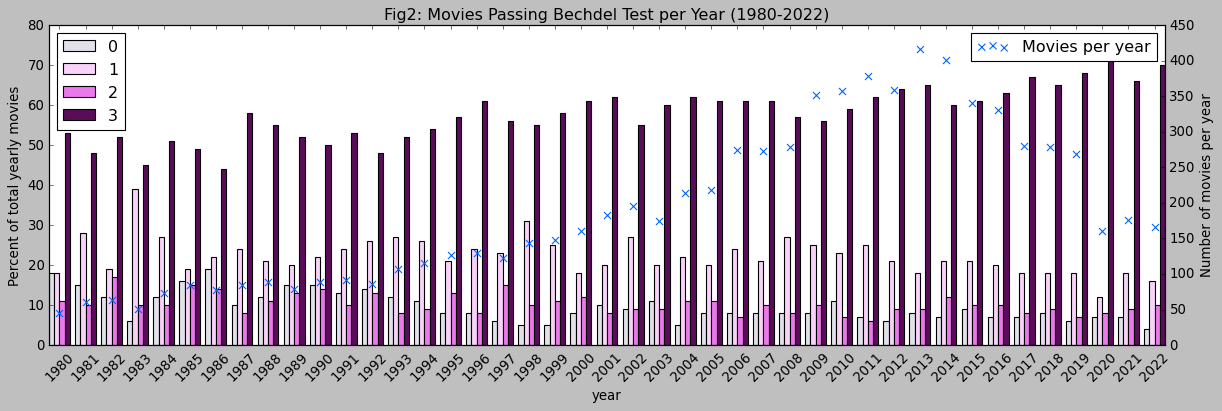

In [35]:
##analyis by year
movies_per_year = bt_movies.groupby("year").size().to_frame().rename(columns = {0 :"size"})
movies_per_year.index = movies_per_year.index.astype('str')
movies_per_year

movie_scores_per_year = bt_movies.groupby(["year","bechdel_score"], as_index = False).size().set_index("year")
movie_scores_per_year.index = movie_scores_per_year.index.astype('str')
movie_scores_per_year["percentage"] = (movie_scores_per_year["size"] / movies_per_year["size"] * 100).round()
movie_scores_per_year

#visual
# legend_labels = ["0: Fails Bechdel Test",  "1: Atleast 2 women", "2: Talking to each other", "3: ~abt a man (Passes BT)"]
title_axis_labels = ["Fig2: Movies Passing Bechdel Test per Year (1980-2022)", "Percent of total yearly movies", 
                     "Number of movies per year", "Movies per year", "Movies_per_Year"]
plot_base_bechdel((18,5), movie_scores_per_year, movies_per_year, "percentage", "size", 
                  title_axis_labels, "bechdel_score", ["#e0e0eb", "#ffccff", "#ff66ff", "#660066"], "#0066ff");


##simplified bechdel scores to only show pass or fail
# movie_scores_per_year = bt_movies.groupby(["year","bt_pass_flag"], as_index = False).size().set_index("year")
# movie_scores_per_year.index = movie_scores_per_year.index.astype('str')
# movie_scores_per_year["perc"] = (movie_scores_per_year["size"] / movies_per_year["size"] * 100).round()
# movie_scores_per_year

# plot_base_bechdel(movie_scores_per_year, movies_per_year, "perc", "size", 
#                   "bt_pass_flag", ["#e0e0eb", "#660066"], "#0066ff")

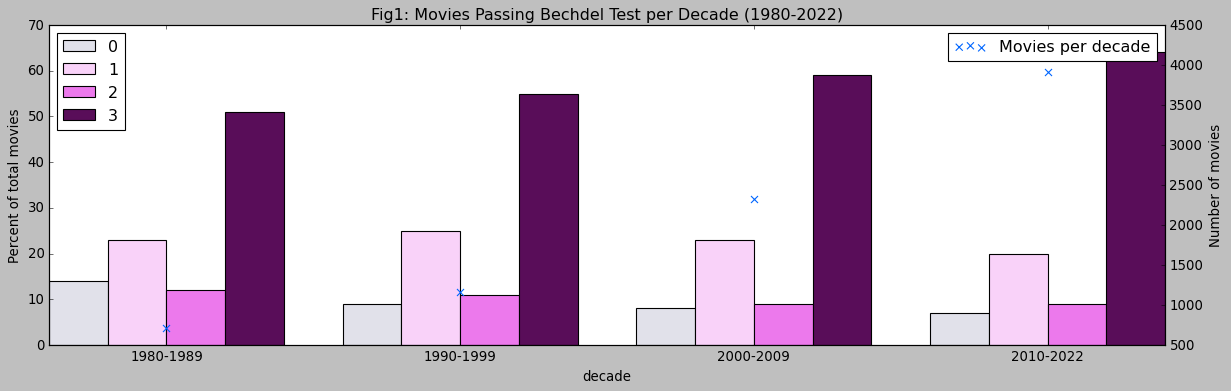

In [6]:
#analysis by decade
movies_per_decade = bt_movies.groupby("decade").size().to_frame().rename(columns = {0 :"size"})
movies_per_decade.index = movies_per_decade.index.astype('str')
movies_per_decade

movie_scores_per_decade = bt_movies.groupby(["decade","bechdel_score"], as_index = False).size().set_index("decade")
movie_scores_per_decade.index = movie_scores_per_decade.index.astype('str')
movie_scores_per_decade["percentage"] = (movie_scores_per_decade["size"] / movies_per_decade["size"] * 100).round()
movie_scores_per_decade

#visual
title_axis_labels = ["Fig1: Movies Passing Bechdel Test per Decade (1980-2022)", "Percent of total movies", 
                     "Number of movies", "Movies per decade","MoviesperDecade"]
plot_base_bechdel((18,5), movie_scores_per_decade, movies_per_decade, "percentage", "size", 
                  title_axis_labels, "bechdel_score", ["#e0e0eb", "#ffccff", "#ff66ff", "#660066"], "#0066ff")

### What does the data show and is the Bechdel dataset truely representative?

An analysis of the Bechdel dataset shows an increase in the number of movies passing the test (meeting all three criteria) over the years. 

However, there is a concern that Bechdel dataset may not be truely representative; since data are self reported it may be that only movies that do well on the Bechdel test are being reported. In order to test the representativeness of the dataset, I tried to compare it to other freely available movie datasets. I chose the [IMDB movies dataset](https://developer.imdb.com/non-commercial-datasets/) since its freely available and covers the timeperiod I'm interested in. The IMDB movie data is also self reported and therefore suffers from its own biases but if at minimum, these movies can be found in the Bechdel dataset then we know that the dataset covers different types of movies that people are watching (whether the movies are popular or unpopular on IMDB is not important at this stage; that fact that movies that are eliciting viewer responses are included in Bechdel would be a sufficient qualitative measure of representativeness for this project).

#### IMDB Data Sourcing and Initial Cleaning/Transformation:

Two IMDB datasets have been used here:
(1) movies_all: contains all IMDB movie data; from this dataset we extract just movies(no TV shows, etc.) 
released between 1980 to 2022. This gives us approximately 380K records

(2) movies_us: We use the region and language features from this dataset to identify US english language movies. 
This gives us about ~3K records

Merging movies_all and movies_us gives us about 1K movies that are US based, in english and released between 1980 and 2022.
Our expectation is that a good proporation of these movies should be found in the Bechdel dataset for us to consider
the later a representative dataset of Hollywood movies. However, we're only able to match about 20% of the data 

In [7]:
## sourcing all IMDB data but we will condense it to just movies (no TV shows, etc.), between 1980 to 2022. 
## ~381,225records
movies_all = pd.read_csv("title.basics.tsv.gz", sep='\t', 
                     usecols = ["tconst", "titleType", "primaryTitle", "startYear", "genres"])
movies_all = movies_all[(movies_all.titleType == "movie")]            #analysis focuses on just movies ~648,658 records

movies_all["startYear"] = pd.to_numeric(movies_all["startYear"], errors ="coerce")  #there are some "\N" values in here 
movies_all =  movies_all[(movies_all.startYear >= 1980) & (movies_all.startYear < 2023)]   #only movies btw 1980-2022 ~381,225records
movies_all.drop_duplicates(subset = ["tconst"], inplace = True)  #~no duplicate records
movies_all["imdbid"] = [i[2:] for i in movies_all["tconst"]]
movies_all.drop(labels = ["tconst", "titleType"], axis =1, inplace = True)

movies_all.head()

,primaryTitle,startYear,genres,imdbid
11636,Tötet nicht mehr,2019.0,"Action,Crime",0011801
13082,Istoriya grazhdanskoy voyny,2021.0,Documentary,0013274
15178,La tierra de los toros,2000.0,\N,0015414
15486,Dama de noche,1993.0,"Drama,Mystery,Romance",0015724
34803,Kate & Leopold,2001.0,"Comedy,Fantasy,Romance",0035423


In [8]:
## Condensing this further by only focusing on US based and english language movies
movies_us = pd.read_csv("title.akas.tsv.gz", sep='\t', usecols = ["titleId", "title", "region","language"])
movies_us = movies_us[(movies_us["region"] == "US") & (movies_us["language"] == "en")]      
movies_us.drop_duplicates(subset = ["titleId"], inplace = True)  #~3173 unique records
movies_us["imdbid"] = [i[2:] for i in movies_us["titleId"]]
movies_us.drop(labels = ["titleId"], axis =1, inplace = True)

movies_us.head()

,title,region,language,imdbid
3402,Les Misérables,US,en,0000969
17472,The Governor,US,en,0005809
25715,Les Misérables,US,en,0008305
31872,Broken Blossoms,US,en,0009968
61305,Lost & Found,US,en,0016283


In [9]:
## merging movies_us with movies_all to get additional details on US EN movies
movies_us = movies_us.merge(movies_all, left_on = "imdbid", right_on= "imdbid", how ="inner")     #~1037 records
movies_us.drop(labels = ["primaryTitle"], axis =1, inplace = True)
movies_us.head()

,title,region,language,imdbid,startYear,genres
0,9 to 5,US,en,0080319,1980.0,Comedy
1,Star Wars: Episode V - The Empire Strikes Back,US,en,0080684,1980.0,"Action,Adventure,Fantasy"
2,Dracula's Last Rites,US,en,0081034,1980.0,Horror
3,The Lion of the Desert,US,en,0081059,1980.0,"Biography,Drama,History"
4,X-Ray,US,en,0082527,1981.0,"Horror,Thriller"


In [10]:
##merging with the bechdel dB to understand the coverage of the Bechdel dataset. The hope is that all or atleast 
##a good proportion of these movies would be in the Bechdel dataset. However, we're only able to match about 230 records
##I'm also surprised to see that its mostly recent movies that are missing. 
imdb_bechdel_coverage = movies_us.merge(bt_movies, left_on = "imdbid", right_on= "imdbid", how ="left")     # records
imdb_bechdel_coverage[~imdb_bechdel_coverage.bechdel_score.isna()].groupby(
                                                                "decade").size().to_frame().rename(columns = 
                                                                                                {0:"no. of missing"})

,no. of missing
decade,
1980-1989,12
1990-1999,22
2000-2009,31
2010-2022,164


### <center>Revenue Based Analysis</center>

In [11]:
#https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time
#DO NOT reload from webpage. Note: Manually cleaned up movie names for the Star Wars, Pirates of the Caribbean, 
#Harry Potter series, etc. in the offline version

top_movies = pd.read_excel("boxoffice.xlsx", usecols= ["Rank","Year","Movie","Distributor","DomesticBoxOffice"])
top_movies = top_movies[(top_movies.Year>=2000) & (top_movies.Year <2023)]  #88 records; dropping 12 pre2000/post2022 movies
top_movies.DomesticBoxOffice = (top_movies.DomesticBoxOffice / 1000000).round()
top_movies["Rank"] = pd.Categorical(top_movies["Rank"], categories = np.arange(1,100), ordered = True)
top_movies.head()

,Rank,Year,Movie,Distributor,DomesticBoxOffice
0,1,2015,Star Wars: Episode VII - The Force Awakens,Walt Disney,937.0
1,2,2019,Avengers: Endgame,Walt Disney,858.0
2,3,2021,Spider-Man: No Way Home,Sony Pict…,814.0
3,4,2009,Avatar,20th Cent…,785.0
4,5,2022,Top Gun: Maverick,Paramount…,719.0


In [12]:
## since the-numbers based data does not contain imdbids, I tried title based merge but stuff like Star Wars gets 
## messed up bec titles are not consisten in both dB. So, I tried incorporating imdbid
## When incorporating imbdids from movies_all, matching just on title leads to errors due to remakes for instance. 
## so we need to match on movie name AND year bec of remakes
top_movies = top_movies.merge(movies_all, left_on = ["Movie","Year"], 
                              right_on = ["primaryTitle","startYear"], how = "inner") 
top_movies[top_movies.imdbid.isna()]      # all matches after cleaning out movie names, e.g. Star Wars - vs : etc.



## However, two names have matched twice; manually reviewing and deleting the incorrect one
## ["Alice in Wonderland" keep "1014759", (https://www.imdb.com/title/tt1014759/?ref_=fn_al_tt_1) and remove 2049386
## and "Beauty and the Beast" keep "tt2771200" (https://www.imdb.com/title/tt2771200/?ref_=fn_al_tt_1) and remove 11861230
top_movies.Movie.value_counts()
top_movies = top_movies[~top_movies.imdbid.isin(["2049386","11861230"])]

print(top_movies.shape[0])
top_movies.head()

88


,Rank,Year,Movie,Distributor,DomesticBoxOffice,primaryTitle,startYear,genres,imdbid
0,1,2015,Star Wars: Episode VII - The Force Awakens,Walt Disney,937.0,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi",2488496
1,2,2019,Avengers: Endgame,Walt Disney,858.0,Avengers: Endgame,2019.0,"Action,Adventure,Drama",4154796
2,3,2021,Spider-Man: No Way Home,Sony Pict…,814.0,Spider-Man: No Way Home,2021.0,"Action,Adventure,Fantasy",10872600
3,4,2009,Avatar,20th Cent…,785.0,Avatar,2009.0,"Action,Adventure,Fantasy",0499549
4,5,2022,Top Gun: Maverick,Paramount…,719.0,Top Gun: Maverick,2022.0,"Action,Drama",1745960


In [13]:
## Now that we have the imdbid, we can incorporate the bechdel data from bt_movies
top_movies = top_movies.merge(bt_movies, left_on = "imdbid", right_on = "imdbid", how = "left") 
top_movies[top_movies.imdbid.isna()].shape ##all match


#Simplifying the genres
# top_movies.sort_values("genres").genres.value_counts()
def simplified(x):
    if x.rfind(",") == -1:
        return x
    else:
        return x[:x.find(",")]
        
top_movies["simplified_genres"] = top_movies["genres"].apply(lambda x:simplified(x))


## Dropping the columns we don't need for further analysis
top_movies.drop(labels = ["primaryTitle", "startYear", "title", "genres"], axis = 1, inplace = True)

top_movies.head()

,Rank,Year,Movie,Distributor,DomesticBoxOffice,imdbid,bechdel_score,year,bt_pass_flag,decade,simplified_genres
0,1,2015,Star Wars: Episode VII - The Force Awakens,Walt Disney,937.0,2488496,3,2015,1,2010-2022,Action
1,2,2019,Avengers: Endgame,Walt Disney,858.0,4154796,3,2019,1,2010-2022,Action
2,3,2021,Spider-Man: No Way Home,Sony Pict…,814.0,10872600,3,2021,1,2010-2022,Action
3,4,2009,Avatar,20th Cent…,785.0,0499549,3,2009,1,2000-2009,Action
4,5,2022,Top Gun: Maverick,Paramount…,719.0,1745960,3,2022,1,2010-2022,Action


In [36]:
# plt.figure(figsize = (7,4))
# sns.scatterplot(data = top_movies, x ="bechdel_score", y = "Rank", hue = "bechdel_score", 
#                 palette = ["#e0e0eb", "#ffccff",
#                            "#ff66ff", "#660066"]).set_title("Fig 3A: All Time Top 100 US Movies");
# plt.ylim(105, -5, -1);
# plt.gca().set_yticks([1,10,20,30,40,50,60,70,80,90,100]);
# plt.gca().set_yticklabels([1,10,20,30,40,50,60,70,80,90,100]);
# plt.xlim(-1, 4, 1);
# plt.gca().set_xticks([-1,0,1,2,3,4]);
# plt.gca().set_xticklabels(["",0,1,2,3,""]);
# plt.legend(loc = 2);
# plt.savefig("BechdelScoreByRank.png")

In [21]:
bo_bs_corr = top_movies[["DomesticBoxOffice","bechdel_score", "bt_pass_flag"]].corr().round(2).loc["DomesticBoxOffice","bechdel_score"]
top_movies[["DomesticBoxOffice","bechdel_score", "bt_pass_flag"]].corr().round(2)

,DomesticBoxOffice,bechdel_score,bt_pass_flag
DomesticBoxOffice,1.00,0.20,0.19
bechdel_score,0.20,1.00,0.94
bt_pass_flag,0.19,0.94,1.00


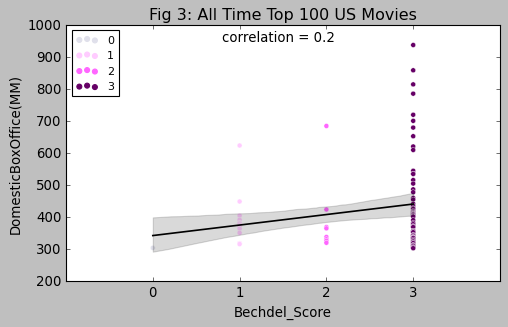

In [47]:
plt.figure(figsize = (7,4))
sns.scatterplot(data = top_movies, x ="bechdel_score", y = "DomesticBoxOffice", hue = "bechdel_score", 
                palette = ["#e0e0eb", "#ffccff","#ff66ff", "#660066"])
sns.regplot(data = top_movies, x ="bechdel_score", y = "DomesticBoxOffice", scatter = False, color = "black")
plt.title("Fig 3: All Time Top 100 US Movies");
plt.gca().ticklabel_format(axis='y', style='plain') 
plt.ylabel("DomesticBoxOffice(MM)")
plt.xlim(-1, 4, 1);
plt.gca().set_xticks([-1,0,1,2,3,4]);
plt.gca().set_xticklabels(["",0,1,2,3,""]);
plt.xlabel("Bechdel_Score")
plt.legend(loc = 2, fontsize = 10);
plt.text(0.8,950,"correlation = 0.2")
plt.savefig("BScorevsBOReturns.png")

In [16]:
# print((top_movies.bt_pass_flag.value_counts()/top_movies.shape[0] * 100).round())

# plt.figure(figsize = (5,5))
# # sns.scatterplot(data = top_movies, x ="bt_pass_flag", y = "DomesticBoxOffice", hue = "bt_pass_flag", 
# #                 palette = ["#e0e0eb", "#660066"]).set_title("Fig 3B-2: All Time Top 100 US Movies");
# sns.regplot(data = top_movies, x ="bechdel_score", y = "DomesticBoxOffice", 
#           scatter_kws = {"color": "#ffccff"},
#           line_kws = {"color": "#660066"})
# plt.title("Fig 3B-2: All Time Top 100 US Movies");

# plt.gca().ticklabel_format(axis='y', style='plain') 
# plt.ylabel("DomesticBoxOffice(MM)")
# # plt.xlim(-1, 2, 1);
# # plt.gca().set_xticks([-1,0,1,2]);
# # plt.gca().set_xticklabels(["","Fail","Pass",""]);
# plt.xlabel(None);
# # plt.legend(loc = 2);
# # plt.savefig("BTFlagByBOReturns.png")

#### Role of Bechdel Scores in Predicting Box Office Performance

While there are likely a lot of factors that go into making a movie a success, such as the budget, plot/genre, cast, etc., it appears that bechdel scores do have some predictive power about whether the movie will be a top grosser or not as shown in Table 1 (p = 0.012).

In [18]:
model = smf.ols("DomesticBoxOffice ~ bechdel_score", data = top_movies).fit()
model.get_robustcov_results().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,341.5739,28.106,12.153,0.000,285.701,397.447
bechdel_score,32.8363,12.759,2.574,0.012,7.473,58.200


#### References:

1. https://glaad.org/whereweareontv21

2. https://dykestowatchoutfor.com/the-rule/

3. https://bechdeltest.com/

4. https://developer.imdb.com/non-commercial-datasets/

5. https://bechdeltest.com/api/v1/doc#getAllMovies

6. https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time